# Univariate, Multivariate, Single Step, Multi Step LSTM Time series forecasting 실습 예제
- Univariate vs Multivariate
- Single Step[point]
- Multi Step[range]

(1)forecast a univariate time series
(2)multivariate time series.

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
14개의 기온, 기압, 습도 등의 기후 데이터를 포함하고 있으며 2003년부터 매 10분마다 적재되었음. **실습에서는 09~16년도 만 사용하도록 해요 

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420551, 15)

*매 10분마다 측정해서 1시간에 6개의 observation이 있으며 하루에 144개의 데이터가 있음 

*특정시점에서 6시간뒤의 온도를 예측하는 모형을 생성 
  5일간의 데이터를 사용-> 144*5 = 720개의 데이터를 사용하여 학습. 

*'history_size'는 과거의 정보 'target_size'는 얼마나 먼 미래를 예측하고 싶은지 우리가 원하는예측값의 사이즈 


In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

*학습데이터: 300,000 rows(~2100일) 나머지는 확인 데이터. 


In [7]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
*self데이터만을 사용해서 예측. 

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021481A9CB08>],
      dtype=object)

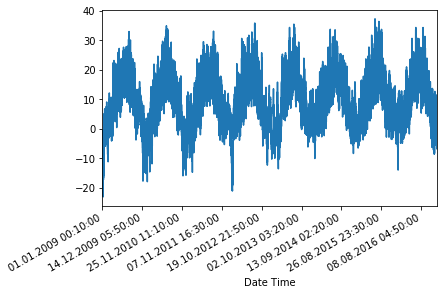

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

**스캐일링하는것은 매우 중요. Standardization은 mean값을 뺸 뒤 std으로 내누는 방식을 택함 (가장 보편적) `tf.keras.utils.normalize`을 사용해서 [0,1]사이의 값으로 스케일링 .

Note: The mean and standard deviation should only be computed using the training data.

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [13]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


*데이터가 생성완료 
하나의 예시 (주어진 정보는 blue, red 의 정보를 예측해야함)

In [16]:
def create_time_steps(length):
    return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mepbp\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

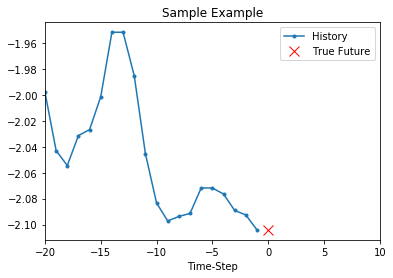

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
베이스라인 --> 과거 20개의 observation의 평균을 예측값으로 설정 


In [19]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\mepbp\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

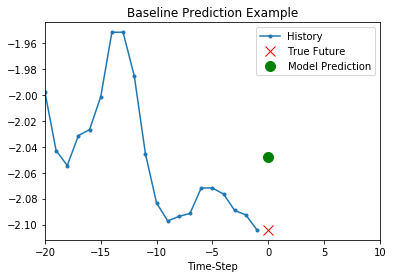

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network (LSTM)

`tf.data`를 통해 셔플링, 배치화 등을 할 수 있음 

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

LSTM모형 정의

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

샘플을 만들어서 체크해보기 

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


**학습 과정 --> 메모리/시간상 각 epoch에 200번의 step만 

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 31ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0263 - val_loss: 0.0195
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model


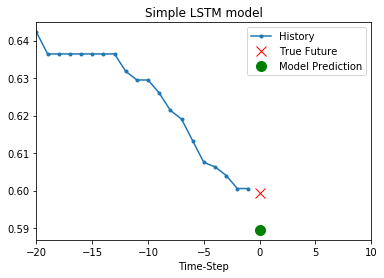

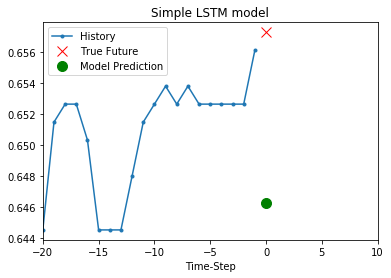

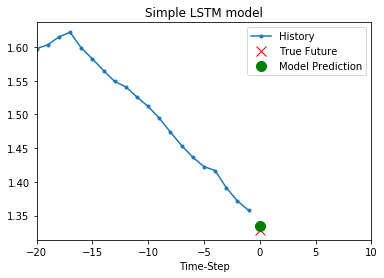

In [25]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

**베이스라인보다 좋아보임! 

## Part 2: Forecast a multivariate time series

원 데이터에는 14개의 feature가 포함되어있으나 예쩨에서는 3개만 포함. (온도, 기압, air density)

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


각각의 feature의 raw data 확인 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002148B3F9348>,
      dtype=object)

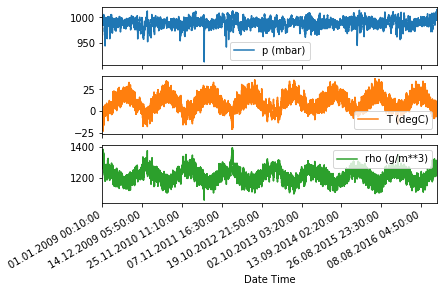

In [28]:
features.plot(subplots=True)

데이터에 처음 해야할 일은 언제나 Standardization!!

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

### Single step model
Single Step에서는 과거를 통해 한개의 포인트를 예측 

위의 예제와 같은 윈도우를 취함. 

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

네트워크는 지난 5일 (720개의 값) 의 데이터가 매 시간 측정됨. 이 예제에서는 1시간동안 큰 변화가 없다는 가정하에 시간당의 샘플링을 취함. 따라서 지난 720개가 아닌 120개의 데이터가 지난 5일간의 과거를 표현. Single Step Prediction a모형에서는 12시간 뒤의 데이터포인트였으나 이번에는 72개 뒤의 값을 책정 (12*6) 

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [36]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 29s 146ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2623 - val_loss: 0.2432
Epoch 3/10
200/200 [==============================] - 26s 132ms/step - loss: 0.2610 - val_loss: 0.2465
Epoch 4/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2569 - val_loss: 0.2446
Epoch 5/10
200/200 [==============================] - 26s 128ms/step - loss: 0.2261 - val_loss: 0.2339
Epoch 6/10
200/200 [==============================] - 26s 128ms/step - loss: 0.2412 - val_loss: 0.2695
Epoch 7/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2402 - val_loss: 0.2528
Epoch 8/10
200/200 [==============================] - 26s 128ms/step - loss: 0.2397 - val_loss: 0.2376
Epoch 9/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2449 - val_loss: 0.2447
Epoch 10/10
200/200 [=========

In [38]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

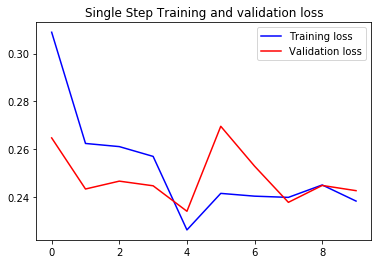

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
모형이 학습이되었으니 예측값을 생성해보자. 
3개의 feature의 5일간의 시간당 과거값을 사용 (120개의 데이터들)하여 온도값을 예측. 
예측값은 하루뒤의 값을 예측하도록 설정 

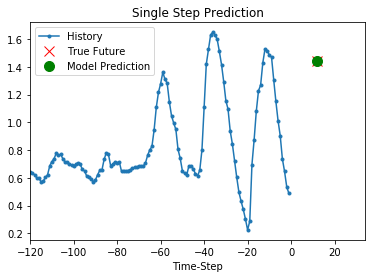

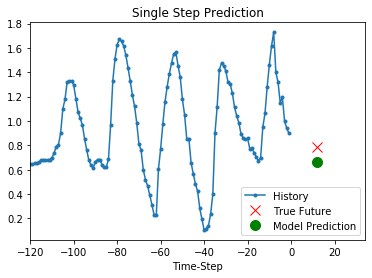

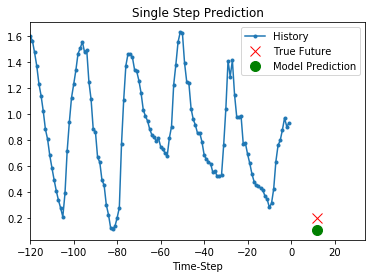

In [40]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, 'Single Step Prediction')
    plot.show()

### Multi-Step model
멀티스텝 모형에서는 과거가 주어졌을때 미래 값의 Range를 예측하도록 설정. (Sequence를 예측)

멀티스텝모형에서 역시 학습 데이터는 과거 5일간의 시간당 샘플된 데이터를 사용. 이 모형에서는 다음 12시간동안의 온도를 예측 (매 10분마다 측정된 값이므로 72개의 예측값을 뱉어내야 함) 


In [41]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

샘플 엿보기

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [43]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [44]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()



```
# This is formatted as code
```

플랏을 그릴때는 과거와 미래값은 시간당 데이터로 표현

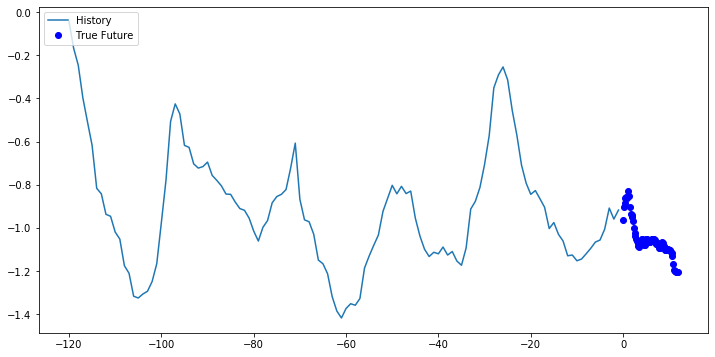

In [45]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

조금 더 복잡한 모형이라 두개의 LSTM레이어를 쌓도록 함. 
Dense Layer는 72개의 아웃풋을 생성 

In [46]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [47]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [48]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 59s 293ms/step - loss: 0.5012 - val_loss: 0.3008
Epoch 2/10
200/200 [==============================] - 51s 256ms/step - loss: 0.3480 - val_loss: 0.2867
Epoch 3/10
200/200 [==============================] - 50s 251ms/step - loss: 11.9973 - val_loss: 0.2956
Epoch 4/10
200/200 [==============================] - 49s 246ms/step - loss: 0.2943 - val_loss: 0.2196
Epoch 5/10
200/200 [==============================] - 50s 250ms/step - loss: 0.2075 - val_loss: 0.1964
Epoch 6/10
200/200 [==============================] - 49s 245ms/step - loss: 0.2082 - val_loss: 0.2021
Epoch 7/10
200/200 [==============================] - 52s 258ms/step - loss: 0.2004 - val_loss: 0.2071
Epoch 8/10
200/200 [==============================] - 50s 251ms/step - loss: 0.1969 - val_loss: 0.1945
Epoch 9/10
200/200 [==============================] - 49s 245ms/step - loss: 0.1990 - val_loss: 0.1832
Epoch 10/10
200/200 [========

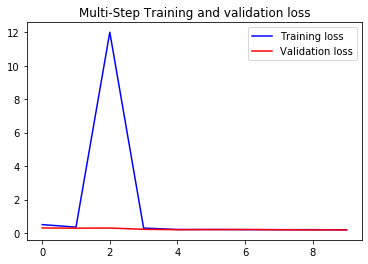

In [49]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

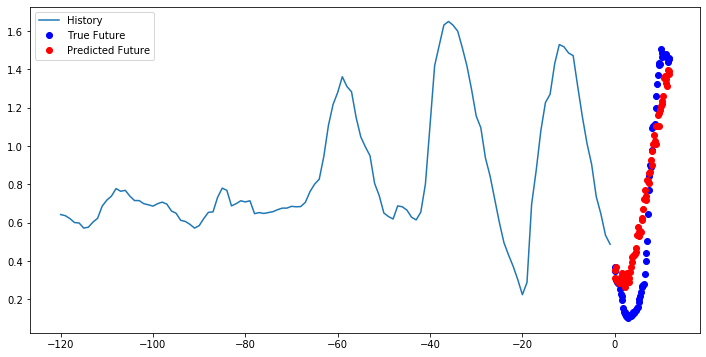

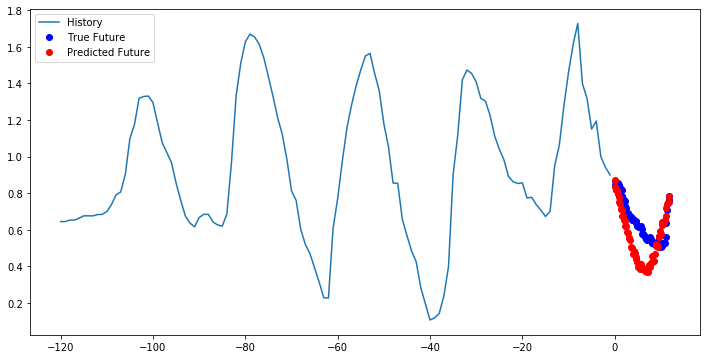

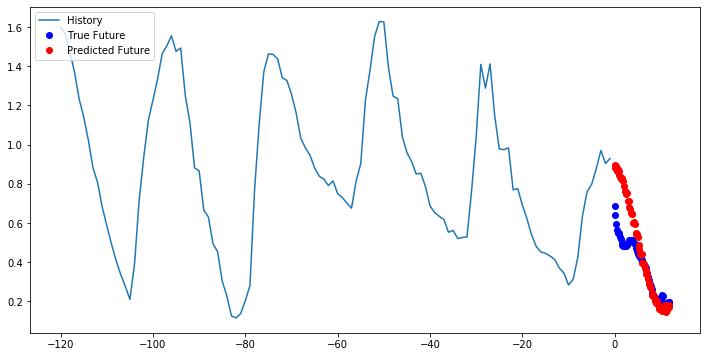

In [50]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

[[북경의 Air Pollution 데이터]]

*   No: row number
*   year: year of data in this row
*   month: month of data in this row
*   day: day of data in this row
*   hour: hour of data in this row
*   pm2.5: PM2.5 concentration
*   DEWP: Dew Point
*   TEMP: Temperature
*   PRES: Pressure
*   cbwd: Combined wind direction
*   Iws: Cumulated wind speed
*   Is: Cumulated hours of snow
*   Ir: Cumulated hours of rain

In [51]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
#dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


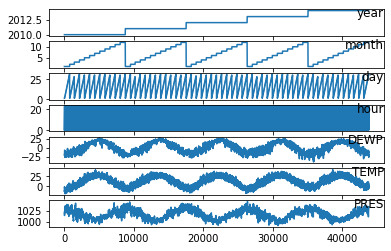

In [52]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

*1시간 뒤의 pollution을 지난 24시간의 데이터를 통해서 예측 